## LVV-T2117 Report

In [1]:
from astropy.time import Time, TimeDelta
from matplotlib import pylab as plt
import numpy

from lsst_efd_client import EfdClient
efd = EfdClient('summit_efd')

### Process

As described in the test case, the data being analyzed here are the result of an in situ measurement technique.
A script polls a particular topic, in this case `lsst.sal.MTM1M3.logevent_heartbeat` at a regular interval.
It then records the system time before and after the EFD query as well as the relevant timestamps from the message as well as the message sequence number (to deduplicate measurements).
This informtion is read into a numpy array.

Once we have the timestamps in memory, we can compute the time window.
We use the time of the first message and then 5 days after that as the window: `2021-09-15T20:24:09.054 -- 2021-09-20T20:24:09.054`.

In [2]:
summit_vals = numpy.genfromtxt('sept_hbeat.log', names=True, dtype=None, delimiter=',')

t1 = Time(summit_vals['private_sndStamp'][0], format='unix', scale='tai')
t2 = t1 + TimeDelta(5*24*3600, format='sec')
t1u = t1.unix
t2u = t2.unix

print(t1.isot, '--', t2.isot)

2021-09-15T20:24:09.054 -- 2021-09-20T20:24:09.054


In [3]:
span = Time(summit_vals['private_sndStamp'][-1], format='unix', scale='tai') - t1
print(f"Span of full sample: {span.value:.2f} days")

Span of full sample: 5.08 days


There was a period where the M1M3 subsystem was under active use.
In order for data from that period not to influence the analysis, we clip those data out.
The range is approximate and is informed by conversation in slack as well as looking at system summary states in the EFD for times in that range.

In [4]:
gaps = [(Time('2021-09-16T12:00', format='isot', scale='tai'), Time('2021-09-16T20:45', format='isot', scale='tai')),]

### Analysis

We now compute the latency and exclude informtion in the exclusion region around when the M1M3 subsystem was actively in use.
Then we plot the results.

In [5]:
idx = numpy.isfinite(summit_vals['private_seqNum']) & numpy.isfinite(summit_vals['private_sndStamp'])

times = Time(summit_vals['private_sndStamp'][idx], format='unix', scale='tai')

diff = []
dates = []
last_seq = None
for a, u, date, s in zip(summit_vals['now_after_query'][idx], times.unix, times.datetime, summit_vals['private_seqNum'][idx]):
    # Skip if we already saw this message.
    # This avoids double counting messages with latency hihger than my sampling rate
    # For the sample selected from the first 5 days of the run, this trims out about 400 samples
    if s == last_seq:
        continue
    d = a - u + 37  # The machine time is in UTC, but the sndStamp is in TAI
    in_gap = False
    for gap in gaps:
        if u > gap[0].unix and u < gap[1].unix:
            in_gap = True
    if not in_gap and u > t1u and u < t2u:
        dates.append(date)
        diff.append(d)
    last_seq = s

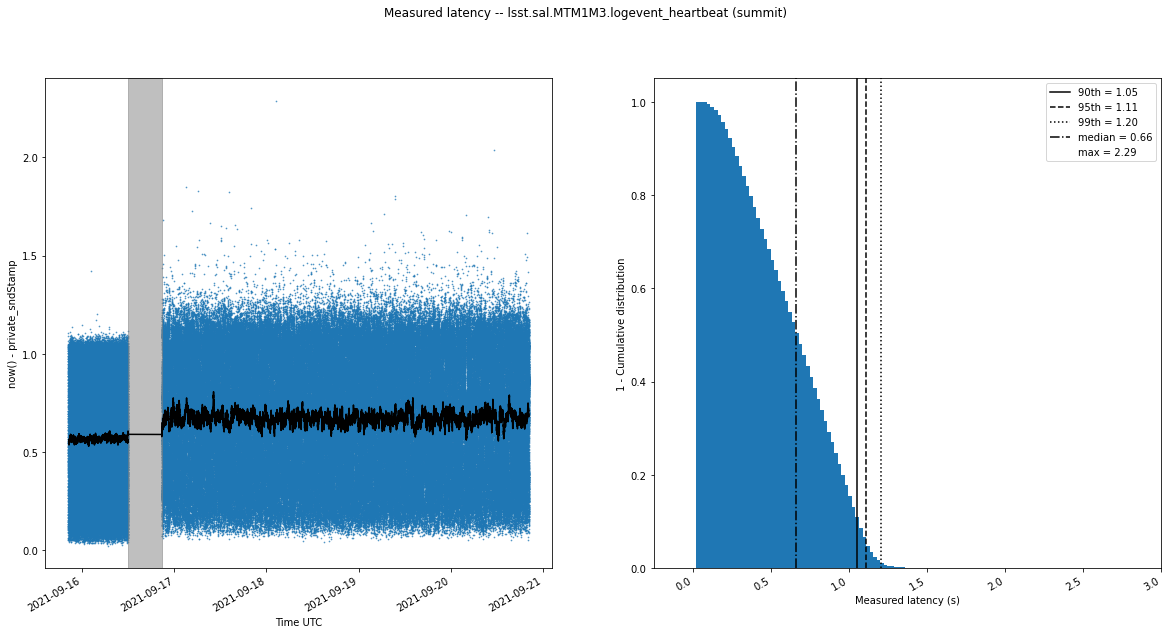

In [6]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

tidx = numpy.where(numpy.array(diff)<20.)
tdiff = numpy.array(diff)[tidx]
tdates = numpy.array(dates)[tidx]
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
_ = fig.suptitle('Measured latency -- lsst.sal.MTM1M3.logevent_heartbeat (summit)')
scat = ax0.scatter(tdates, tdiff, alpha=0.7, s=0.5)
xl0 = ax0.set_xlabel('Time UTC')
yl0 = ax0.set_ylabel('now() - private_sndStamp')
rm = ax0.plot(tdates[499:-500], running_mean(tdiff, 1000), c='black')
hist = ax1.hist(tdiff, cumulative=-1, bins=100, density=True)
yl1 = ax1.set_ylabel('1 - Cumulative distribution')
xl1 = ax1.set_xlabel('Measured latency (s)')
xr1 = ax1.set_xlim(-0.25, 3)

for gap in gaps:
    ax0.axvspan(gap[0].datetime, gap[1].datetime, alpha=0.5, color='grey')
vl = ax1.axvline(numpy.percentile(tdiff, 90), c='black', ls='solid', label=f'90th = {numpy.percentile(tdiff, 90):.2f}')
v2 = ax1.axvline(numpy.percentile(tdiff, 95), c='black', ls='dashed', label=f'95th = {numpy.percentile(tdiff, 95):.2f}')
v3 = ax1.axvline(numpy.percentile(tdiff, 99), c='black', ls='dotted', label=f"99th = {numpy.percentile(tdiff, 99, interpolation='lower'):.2f}")
v4 = ax1.axvline(numpy.median(tdiff), c='black', ls='dashdot', label=f'median = {numpy.median(tdiff):.2f}')
v4 = ax1.axvline(6, c='black', ls='dashdot', alpha=0.0, label=f'max = {numpy.max(tdiff):.2f}')
leg = ax1.legend()
plt.gcf().autofmt_xdate()

The left pane shows the latency as a function of time.
On the far left part is a region where the M1M3 subsystem was disabled.
The right side is when M1M3 was enabled, but was not in active use, so publishing at the quiescent rate.
The region excluded in this analysis because the M1M3 subsystem was in active use is shown as a vertical grey bar.
The right pane shows the distribtion with various percentiles marked.
The important one is that the 99th percentile is below the 4 seconds required by this test.
We also not that the maximum value of 2.29 is below the maximum allowed of 20 seconds.